In [47]:
%matplotlib inline

from matplotlib import pyplot as plt
import tfs

from config import NTURNS, BEAM, SAMPLE_INDEX, DENOISED_INDEX, TOTAL_TURNS
from rdt_constants import NORMAL_SEXTUPOLE_RDTS, FREQ_OUT_DIR
from rdt_functions import (
    get_rdts_from_optics_analysis,
    get_tbt_path,
    run_harpy,
)
plt.rcParams.update({"font.size": 16})
COLOURS = [
    "#0072B2",  # Blue
    "#D55E00",  # Red
    "#009E73",  # Green
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#F0E442",  # Yellow
    "#CC79A7",  # Pink
    "#000000",  # Black
]
cleaned_path = get_tbt_path(beam=BEAM, nturns=NTURNS, index=DENOISED_INDEX)
# noisy_path = get_tbt_path(beam=BEAM, nturns=TOTAL_TURNS, index=SAMPLE_INDEX)
noisy_path = get_tbt_path(beam=BEAM, nturns=NTURNS, index=SAMPLE_INDEX + "_split")
nonoise_path = get_tbt_path(beam=BEAM, nturns=TOTAL_TURNS, index=-1)
CLEAN_HARPY = False

In [48]:
run_harpy(BEAM, cleaned_path, clean=False)
print("Done running Harpy on cleaned data from the autoencoder")

Done running Harpy on cleaned data from the autoencoder


In [49]:
# run_harpy(BEAM, new_noisy_path, clean=CLEAN_HARPY)
run_harpy(BEAM, noisy_path, clean=CLEAN_HARPY)
print("Done running Harpy on noisy data, cleaned using Harpy")

Done running Harpy on noisy data, cleaned using Harpy


In [50]:
run_harpy(BEAM, nonoise_path, clean=False)
print("Done running Harpy on no noise data")

Done running Harpy on no noise data


BPM.31L4.B1
BPM.31L4.B1


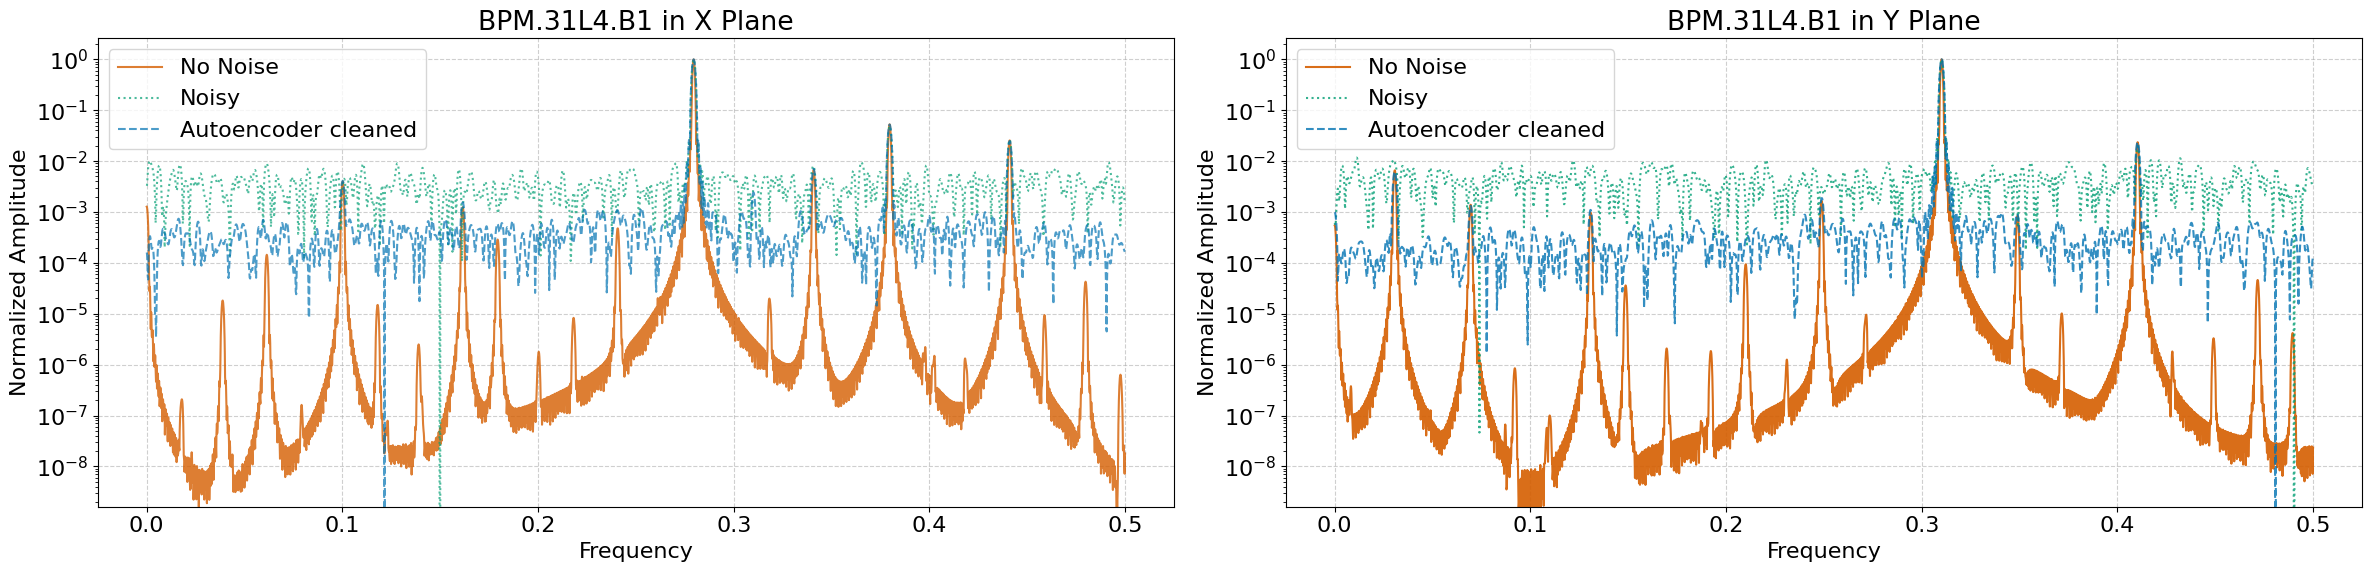

In [51]:
def normalise_df(df: tfs.TfsDataFrame):
    return (df - df.min()) / (df.max() - df.min())

plt.rcParams.update({"font.size": 16})

# Define mapping for each state
states = ["clean", "noisy", "nonoise"]
# Map state to plot labels (note: we assume that "nonoise" is the denoised case)
labels = {
    "nonoise": "No Noise",
    "noisy": "Harpy Cleaned" if CLEAN_HARPY else "Noisy",
    "clean": "Autoencoder cleaned",
}
# Define linestyles (None means default solid line)
linestyles = {"nonoise": None, "noisy": "dotted", "clean": "dashed"}
colors = {"nonoise": COLOURS[1], "noisy": COLOURS[2], "clean": COLOURS[0]}

# Assuming you have these path variables already defined:
# cleaned_path, noisy_path, nonoise_path
paths = {
    "clean": cleaned_path,
    # 'noisy': new_noisy_path,
    "noisy": noisy_path,
    "nonoise": nonoise_path,
}
BPM_INDEX = 111

# Dictionaries to hold frequency and amplitude data for X and Y
freqs_x, amps_x = {}, {}
freqs_y, amps_y = {}, {}

for state in states:
    path = paths[state]
    # Load and normalize X data
    freqs_x[state] = tfs.read(FREQ_OUT_DIR / (path.name + ".freqsx"))
    amps_x[state] = normalise_df(tfs.read(FREQ_OUT_DIR / (path.name + ".ampsx")))

    # Load and normalize Y data
    freqs_y[state] = tfs.read(FREQ_OUT_DIR / (path.name + ".freqsy"))
    amps_y[state] = normalise_df(tfs.read(FREQ_OUT_DIR / (path.name + ".ampsy")))

# Select a BPM channel using the same index for both X and Y
BPM_NAME_x = amps_x["clean"].columns[BPM_INDEX]
print(BPM_NAME_x)
BPM_NAME_y = amps_y["clean"].columns[BPM_INDEX]
print(BPM_NAME_y)

# Define the order in which to plot (to match your example: denoised, noisy, then clean)
plot_order = ["nonoise", "noisy", "clean"]

# Create subplots for X and Y
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Plot X plane data
for state in plot_order:
    axs[0].plot(
        freqs_x[state][BPM_NAME_x],
        amps_x[state][BPM_NAME_x],
        label=labels[state],
        linestyle=linestyles[state],
        color = colors[state],
        alpha=0.8 if state == "nonoise" else 0.7,
    )
axs[0].set_title(f"{BPM_NAME_x} in X Plane")
axs[0].legend()

# Plot Y plane data
for state in plot_order:
    axs[1].plot(
        freqs_y[state][BPM_NAME_y],
        amps_y[state][BPM_NAME_y],
        label=labels[state],
        linestyle=linestyles[state],
        color = colors[state],
        alpha=0.9 if state == "nonoise" else 0.8,
    )
axs[1].set_ylabel("Normalized Amplitude")
axs[1].set_title(f"{BPM_NAME_y} in Y Plane")
for ax in axs:
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_yscale("log")
    ax.set_ylim(10**-8.791334934248553, 10**0.4132279093016276)


plt.tight_layout()
filename = "harpy_spectrum.png" if CLEAN_HARPY else "harpy_spectrum_noisy.png"
plt.savefig(filename, bbox_inches="tight", dpi=300)
plt.show()


In [52]:
print("Running optics analysis on the data")
cleaned_dfs = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=cleaned_path)
# hcleaned_dfs = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=new_noisy_path)
hcleaned_dfs = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=noisy_path)
nonoise_rdts = get_rdts_from_optics_analysis(beam=BEAM, tbt_path=nonoise_path)
print("Done running optics analysis")

Running optics analysis on the data


NaNs found, weights are not used.
NaNs found, weights are not used.


Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.


Tunes for beam 1: [np.float64(0.279498928605), np.float64(0.310174189918)]


NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.


Tunes for beam 1: [np.float64(0.27949901301), np.float64(0.310174179755)]


Zeros found, weights are not used.
Zeros found, weights are not used.
NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
NaNs found, weights are not used.
NaNs found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.
Zeros found, weights are not used.


Tunes for beam 1: [np.float64(0.279499053955), np.float64(0.310174942017)]
Done running optics analysis


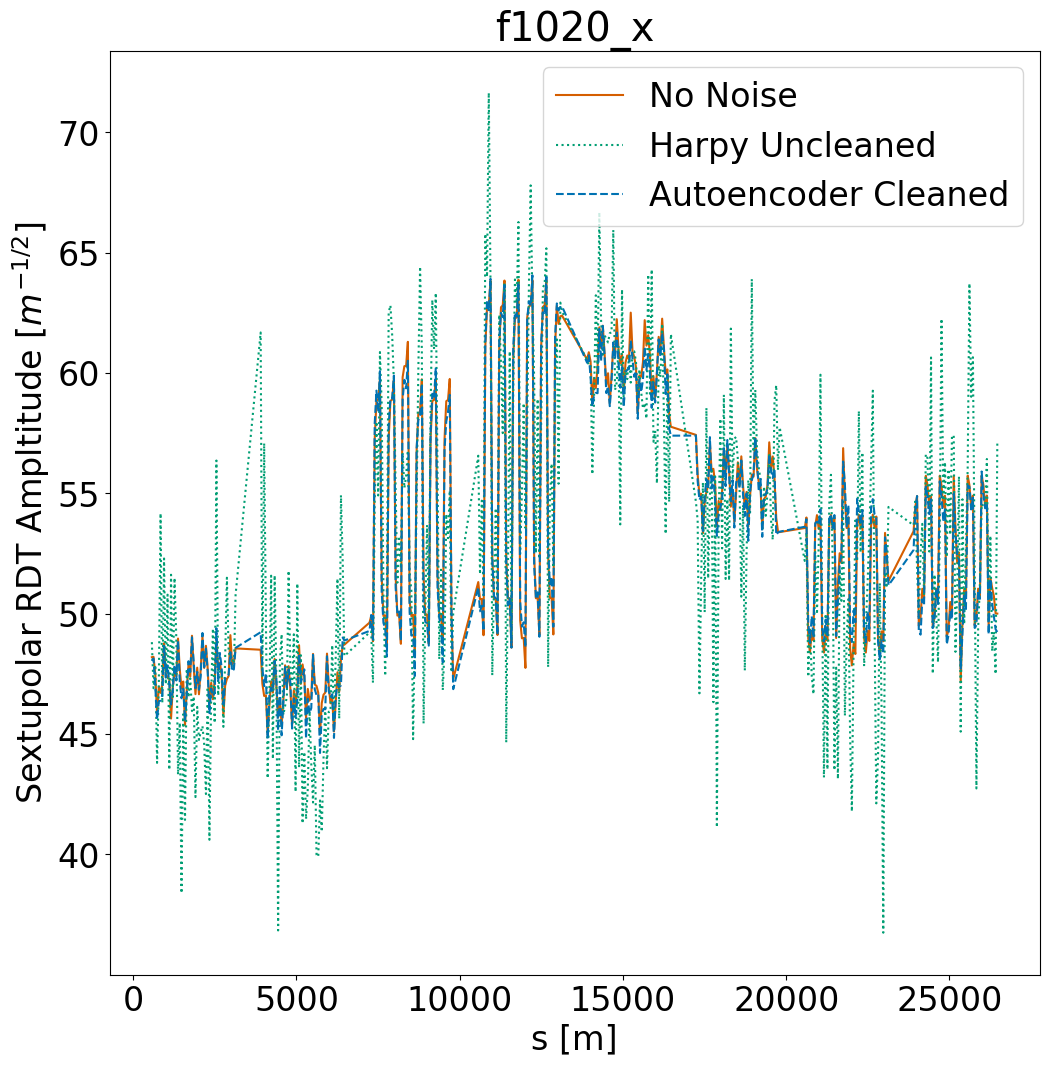

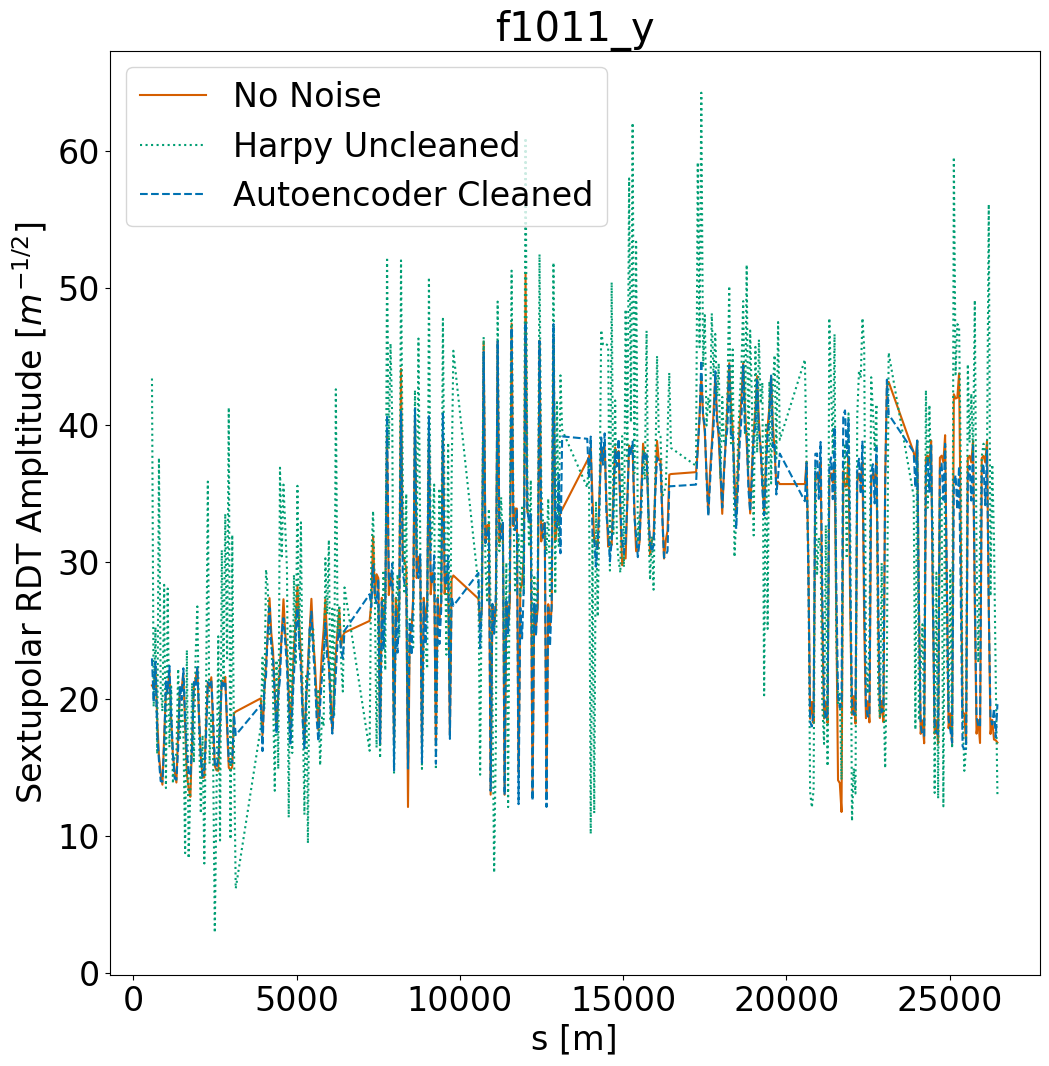

In [53]:
plt.rcParams.update({"font.size": 24})
for rdt in ["f1020_x", "f1011_y"]:
    plt.figure(figsize=(12, 12))
    plt.plot(nonoise_rdts[rdt]["S"], nonoise_rdts[rdt]["AMP"], label="No Noise", color=COLOURS[1])
    plt.plot(
        hcleaned_dfs[rdt]["S"],
        hcleaned_dfs[rdt]["AMP"],
        label=f"Harpy {CLEAN_HARPY and 'Cleaned' or 'Uncleaned'}",
        color=COLOURS[2],
        linestyle="dotted",
        # marker="+",
    )
    plt.plot(
        cleaned_dfs[rdt]["S"], cleaned_dfs[rdt]["AMP"], label="Autoencoder Cleaned",
        color=COLOURS[0],
        linestyle="dashed",
        # marker="x",
    )
    plt.title(rdt)
    plt.xlabel("s [m]")
    plt.ylabel("Sextupolar RDT Ampltitude [$m^{-1/2}$]")
    plt.legend()
    if not CLEAN_HARPY:
        rdt += "_unclean"
    plt.savefig(rdt, bbox_inches="tight", dpi=300)
    plt.legend()
plt.show()